In [1]:
import os
clear = lambda: os.system('cls')
clear()
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import folium
import math
import time
from selenium import webdriver
from tqdm.notebook import tqdm
import random
import osmnx as ox
import time
import geopandas as gpd
import datetime
import networkx as nx
from IPython.display import IFrame
from gmplot import GoogleMapPlotter
import gmplot
import imgkit
import os.path
import pyarrow.feather as feather
from scipy.interpolate import interp1d
import os
import imageio
import geohash_hilbert as ghh
import matplotlib.patches as mpatches
from pyproj import Proj
from sklearn.cluster import KMeans
import seaborn as sb; sb.set()
import csv
from collections import Counter
import glob
from os import listdir
from os.path import isfile, join
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from simpledbf import Dbf5
import pickle
from collections import deque


import keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score as imba
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

def folder_creator(name_of_folder,path):
    cwd = os.getcwd()
    os.chdir(path)
    try:  
        os.mkdir(name_of_folder)  
    except OSError as error:  
        pass
    os.chdir(cwd)
    return()

def correct_df(df_file):
    empty = []
    for item in range(0,len(df_file)):
        line = df_file.loc[item].tolist()
        empty.append(line)
    return(np.array(empty))

def get_lane_position_num(temp_file):
    if ('lane position' in list(temp_file.columns)) == True:
        for line in range(0,len(temp_file)):
            if temp_file['lane position'][line] == 'EDGE':
                temp_file.at[line,'lane position number'] = 1
            else:
                temp_file.at[line,'lane position number'] = 0
        temp_file = temp_file.drop(columns=['lane position'])          
    return(temp_file)

def get_columns_2_list_2(list_of_input_col_strings,veh_example_df):
    num_of_cols = []
    for thing in list_of_input_col_strings:
        num_of_cols.append(veh_example_df.columns.get_loc(thing))
    return(num_of_cols)

def extract_from_file_2(file, list_of_columns_inputs, col_2_pred, start, time_window, future_time_step,starting_future_point = 0):
    X = []
    y = []
    yy = []
    XX = []
    check = False
    if len(file) - start - time_window - future_time_step >= 0:
        for timestep in range(start,start + time_window):
            temp = []
            for col in list_of_columns_inputs: # one timestep_input
                temp.append(file[timestep][col])
            XX.append(temp) # one sequence
        temp = []
        for f_step in range(start +starting_future_point+ time_window,start+starting_future_point+time_window+future_time_step):
            yy.append(file[f_step][col_2_pred])
        XX = np.array(XX)
        y.append(yy)
        X.append(XX)
        X = np.array(X)
        y = np.array(yy)
    else:
        print('error')
    return(X,y)

def create_3d_file_4(file_list,directory,classes_list,timesteps_as_input,timestep_in_future,input_col,pred_col,transpose_mode,PART_SELECT,MODE,start,LOGS = False):

    frames_X = dict()
    frames_y = dict()
    count = 0
    COUNT = 0
    file_list = random.sample(file_list ,len(file_list ))
    for file in tqdm(file_list):
        
        f = directory + "\\" + file
        veh_r = pickle.load( open(f, "rb" ) )
        veh_r = get_lane_position_num(veh_r)
        if LOGS == True:
            print(veh_r['lane change'].unique())
        if file == file_list[0]:
            input_l_num = get_columns_2_list_2(input_col,veh_r) 
            pred_l_num = get_columns_2_list_2([pred_col],veh_r)
        if file == file_list[0] or file == file_list[1]:
            print(input_l_num,pred_l_num)
        needed_len = start + timesteps_as_input + timestep_in_future
        
        if len(veh_r) >= needed_len :
            
            
            veh_r = correct_df(veh_r)
            total_times = len(veh_r)//needed_len
            start_2_give = 0
            if LOGS == True:
                print()
                print('---------------------------------------')
                print('Vehicle length = ',len(veh_r))
                print('Needed length = ', timesteps_as_input + timestep_in_future )
                print('Max possible sequences = ',total_times)

                print('Final number of sequences for sample = Vehicle length - Needed length  = ',total_times)
                print('---------------------------------------')
                
            for times in range(start,total_times):
                if count == 0:
                    print()
                    print('time window: ' + str(round(timesteps_as_input*0.12))+ ' s, predicting after t+ '+str(timestep_in_future)+' second(s) ')
                    print('displaying time window: '+str(timesteps_as_input) + ' + future lane change in the next t+'+str(timestep_in_future)+' second(s)')
                    display(veh_r[input_l_num][start + times:start + times + timesteps_as_input ])
                    display(veh_r[pred_l_num][start + times:start + times + timesteps_as_input + timestep_in_future])
                start_file = start + times*timesteps_as_input
                veh2 = extract_from_file_2(veh_r,input_l_num,pred_l_num,start_file,timesteps_as_input,timestep_in_future,starting_future_point = 0)
                #print(veh2[2])
                
                if LOGS == True:
                    print('X shape: '+str(veh2[0].shape)+' count: '+ str(count))
                    print('y shape: '+str(veh2[1].shape)+' count: '+ str(count))
                    print('y: ',veh2[1])
                for fr in range(0,len(veh2[0])):
                    frames_X[count] = veh2[0][fr]
                    frames_y[count] = veh2[1][fr] 
                    
                    if count == 1000000000:
                        print('example of X and y')
                        print(input_col)
                        print()
                        print(frames_X[count][0:5],' < ------------ data')

                        print([pred_col])
                        print(frames_y[count][0:5],' < ------------ labels')
                        print(frames_X[count].shape,frames_y[count].shape)
                        print()
                    count = count +1
                
    X_all = np.dstack(frames_X.values())
    y_all = np.dstack(frames_y.values())
    
    print('Reshaping: ')
    print('samples x  timesteps x features')
    X_all = X_all.reshape(X_all.shape[2],X_all.shape[0],X_all.shape[1])
    y_all = y_all.reshape(y_all.shape[2],y_all.shape[0],y_all.shape[1])
    print(X_all.shape)
    print(y_all.shape)

    return(X_all,y_all)

SQLalchemy is not installed. No support for SQL output.


Using TensorFlow backend.


In [2]:
name_of_intersection = 'PANEPISTIMIOY - 28HS OKTOMVRIOU'
directory = 'C:\\Users\\jason\\Diplomatiki\\Datafiles\\location 10\\' + name_of_intersection +'\\full_final_lstm_dfs_txts_3\\'
# pickle.load( open(directory + '\\final_lstm_files\\'+ name2_Save +'.txt', "rb" ) )
files_2_load2 = []
for file in os.listdir(directory):
    files_2_load2.append(file)
print('loaded ' + str(len(files_2_load2)) + ' files')
display(files_2_load2[0:5])

f = directory + "\\" + random.choice(files_2_load2)
if '.txt' in f:
    veh = pickle.load( open(f, "rb" ) )
#display(veh)
print('----------------')
#print('Columns & Values')
print()
#for col in veh.columns.tolist():
    #print(col+': ' + str(veh[col][0]))
#print('----------------')
no_ch = 0
y_ch = 0
y_files = []
no_files = []
for file in files_2_load2:
    if file[12:13] == 'n':
        no_ch = no_ch+1
        no_files.append(file)
    else:
        y_ch = y_ch+ 1
        y_files.append(file)
print('vehicles DID change lane: ' + str(y_ch) + ' vehicles that DID NOT changed lane: ' + str(no_ch))
print('Percent(%) of lane change: ' +str(round(y_ch/(no_ch+y_ch),2)))

keep_analogy = True
ratio = 1
if keep_analogy == True:
    no_fin = no_files[0:len(y_files)]
    files_2_load2_ed = y_files + no_fin[0:round(ratio*len(no_fin))]
    print()
    print('Using only '+str(round(ratio*100)) + '% of vehicles that did not change lane')
    print('Final selection: ' + str(len(files_2_load2_ed))+' vehicles')
    no_ch_ed = 0
    y_ch_ed = 0
    no_files_ed = []
    y_files_ed = []
    for file in files_2_load2_ed:
        if file[12:13] == 'n':
            no_ch_ed = no_ch_ed+1
            no_files_ed.append(file)
        else:
            y_ch_ed = y_ch_ed+1
            y_files_ed.append(file)
    print()
    print()
    print('--------------------- Vehicles analogy -------------------------')
    print('vehicles that changed lane: ' + str(y_ch_ed) + ' vehicles that DID NOT change : ' + str(no_ch_ed))
    print('Percent(%) of lane change: ' +str(round(y_ch_ed/(no_ch_ed+y_ch_ed),2)))
    print('----------------------------------------------------------------')
    
    # using only vehicles that lane changed since those vehicles include also the lane keeping part


loaded 4929 files


['lane change n Heavy movement E-S1278 1000_1030 349.txt',
 'lane change n Heavy movement E-S1916 1000_1030 645.txt',
 'lane change n Heavy movement E-S199 0800_0830 188.txt',
 'lane change n Heavy movement E-S2193 0900_0930 233.txt',
 'lane change n Heavy movement E-W1013 0800_0830 131.txt']

----------------

vehicles DID change lane: 2024 vehicles that DID NOT changed lane: 2905
Percent(%) of lane change: 0.41

Using only 100% of vehicles that did not change lane
Final selection: 4048 vehicles


--------------------- Vehicles analogy -------------------------
vehicles that changed lane: 2024 vehicles that DID NOT change : 2024
Percent(%) of lane change: 0.5
----------------------------------------------------------------


In [3]:
veh

,speed,lat_acc,lon_acc,abs delta lat_acc,abs delta lon_acc,delta lat_acc,delta lon_acc,delta displacement,abs delta displacement,delta speed,...,N,NE,E,SE,S,SW,W,NW,head_line,lane change
0,0.18882,0.52613,0.65436,0.00235,0.00158,0.50206,0.48685,0.53306,0.06612,0.63105,...,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,0.19126,0.52495,0.65525,0.00263,0.00201,0.50192,0.48707,0.53306,0.06612,0.63213,...,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,0.19360,0.52359,0.65422,0.00305,0.00234,0.50171,0.48483,0.53719,0.07438,0.63197,...,0.395371,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
3,0.19515,0.52211,0.65296,0.00332,0.00286,0.50157,0.48457,0.52066,0.04132,0.63073,...,0.395148,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,0.19483,0.52053,0.65006,0.00353,0.00660,0.50146,0.48265,0.52893,0.05785,0.62775,...,0.396337,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,0.09852,0.56377,0.65245,0.01064,0.00035,0.49789,0.48586,0.45455,0.09091,0.62913,...,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
163,0.09892,0.55865,0.65223,0.01146,0.00051,0.49747,0.48578,0.48760,0.02479,0.62889,...,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
164,0.09920,0.55438,0.65221,0.00956,0.00004,0.49843,0.48602,0.45455,0.09091,0.62871,...,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
165,0.09947,0.55114,0.65211,0.00726,0.00024,0.49959,0.48591,0.50000,0.00000,0.62868,...,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [4]:
def counter_of_lane_change(veh_array,st_point,ending_point,col_num):
    count_1 = 0
    count_0 = 0
    for thing in range(st_point,ending_point):
        if veh_array[thing][col_num] == 0:
            count_0 = count_0 +1
        elif veh_array[thing][col_num] == 1:
            count_1 = count_1 +1
    return(count_0,count_1,veh_array[st_point][col_num])

def rename_context(file,current_step,future_step,logs,col_2_pred):
    #current_step is in the END of time window
    nos, yes, start_st = counter_of_lane_change(file,current_step,future_step,col_2_pred)
    if nos == 0:
        state_name = 'lane change'
        state = 1
    elif yes == 0:
        state_name = 'no change'
        state = 0
    else:
        state_name ='in between'
        state = 1
    if logs == True:
        print(state_name)
    return(state)

def get_lane_position_num(temp_file):
    if ('lane position' in list(temp_file.columns)) == True:
        for line in range(0,len(temp_file)):
            if temp_file['lane position'][line] == 'EDGE':
                temp_file.at[line,'lane position number'] = 1
            else:
                temp_file.at[line,'lane position number'] = 0
        temp_file = temp_file.drop(columns=['lane position'])          
    return(temp_file)

def rename_lane_change(now,future):

    if future == 0 and now == 0 :
        ret = 0 
    else:
        ret = 1
    return(ret)

def pre_process_dfs(directory,list_files,input_l,taget_col_name,seq_len,future_step,logs):
    sequential_data = []    
    for veh2 in tqdm(list_files):
        if veh2 == list_files[0]:
            print_m = True
        else:
            print_m = False
        veh2 = pickle.load( open(directory + "\\" + random.choice(y_files_ed), "rb" ) )
        veh2 = get_lane_position_num(veh2)
        new_name = 'future '  + taget_col_name
        veh2[new_name] = veh2[taget_col_name].shift(-future_step)
        veh2 = classify_col(veh2,taget_col_name)
        veh2 = veh2.drop(new_name ,1)
        veh2 = veh2[input_l+['target']]
        veh2.dropna(inplace= True)
        

        prev_time_Steps = deque(maxlen = seq_len )
        
        for i in veh2.values:
            prev_time_Steps.append([n for n in i[:-1]])
            if len(prev_time_Steps) == seq_len:
                if logs == True:
                    print(len(np.array(prev_time_Steps)),i[-1])
                sequential_data.append([np.array(prev_time_Steps),i[-1]])
    
    random.shuffle(sequential_data)
    
    lane_changes = []
    no_lane_changes = []

    for seq,target in sequential_data:
        if target == 0:
            no_lane_changes.append([seq,target])
        elif target == 1:
            lane_changes.append([seq,target])

    random.shuffle(no_lane_changes)
    random.shuffle(lane_changes)

    lower = min(len(lane_changes),len(no_lane_changes))
    print('Lane change - Samples:' ,len(lane_changes))
    print('No lane change - Samples:' ,len(no_lane_changes))
    print('Percent of Lane change - Samples :'+str(round(len(lane_changes)/(len(no_lane_changes)+len(lane_changes)),3))+' %')
    print('Threshold of Samples per class:  ',lower)
    lane_changes = lane_changes[:lower]
    spare_no_lane_changes = no_lane_changes[lower:len(no_lane_changes)]
    no_lane_changes = no_lane_changes[:lower]
    
    sequential_data = lane_changes + no_lane_changes

    random.shuffle(sequential_data)
    
    X = []
    y = []
    for seq,target in sequential_data:
        X.append(seq)
        y.append(target)
        
    random.shuffle(spare_no_lane_changes)
    X_ext = []
    y_ext = []
    for seq,target in spare_no_lane_changes:
        X_ext.append(seq)
        y_ext.append(target)
    print('extra no lane change samples: ',len(spare_no_lane_changes))
    print('final count of all samples: ',len(sequential_data))
    return np.array(X),np.array(y),np.array(X_ext),np.array(y_ext)

def classify_col(main_df,taget_col_name_i):
    
    main_df['target'] = list(map(rename_lane_change,main_df[taget_col_name_i],main_df['future lane change']))
    return(main_df)

In [ ]:
veh

In [42]:
# using only vehicles that lane changed since those vehicles include also the lane keeping part
files_2_use = files_2_load2 #y_files_ed # 

input_list = ['lat_acc','speed','veh type value','N', 'NE','E', 'SE', 'S', 'SW', 'W', 'NW', 'head_line']
pred_col = 'lane change'
# veh = pickle.load( open(directory + "\\" + random.choice(files_2_use), "rb" ) )
logs_switch = False
time_window = 42
predict_future_step = 42
all_X, all_y, extra_X, extra_y = pre_process_dfs( directory,files_2_use,input_list,pred_col,time_window,predict_future_step,logs_switch)
print('X shape ',all_X.shape)
print('y shape ',all_y.shape)


Lane change - Samples: 617280
No lane change - Samples: 1065461
Percent of Lane change - Samples :0.367 %
Threshold of Samples per class:   617280
extra no lane change samples:  448181
final count of all samples:  1234560
X shape  (1234560, 42, 12)
y shape  (1234560,)


In [38]:
def get_labels(list_of_lane_ch):
    tags = []
    for thing in list_of_lane_ch:
        if thing == 1:
            tags.append('lane change')
        else:
            tags.append('no lane change')
    return(tags)

def print_final_results(model_file,y_true,dict_location):
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    from sklearn.svm import SVC
    
    from sklearn.metrics import classification_report

  
    y_pred = model_file[dict_location]
    y_test = y_true
    
    
    reform_y_pred = np.squeeze(np.round(y_pred))
    print(classification_report(y_test, reform_y_pred, target_names= ['no lane change','lane change']))
    
    print('-----------------------------------------------------------------------------------------------------------------')
    
   
    
    T_LANE_CH_T_PRED = 0
    F_LANE_CH_F_PRED = 0
    T_LANE_CH_F_PRED = 0
    F_LANE_CH_T_PRED = 0
    counts_of_no = 0
    for t in range(0,len(y_test)):
        if y_test[t] == 1:
            if reform_y_pred [t] == y_test[t]:
                T_LANE_CH_T_PRED = T_LANE_CH_T_PRED +1
            else:
                T_LANE_CH_F_PRED = T_LANE_CH_F_PRED +1
        else:
            if reform_y_pred [t] == y_test[t]:
                F_LANE_CH_F_PRED = F_LANE_CH_F_PRED +1
            else:
                F_LANE_CH_T_PRED = F_LANE_CH_T_PRED +1
    print('counts: ')           
    print('| TP | True - positives | lane change - True prediction: ',T_LANE_CH_T_PRED)
    print('| TN | True - negatives | lane change - False prediction: ',T_LANE_CH_F_PRED)
    print('| FN | False - Negatives | No lane change - True prediction: ',F_LANE_CH_T_PRED)
    print('| TP | True - Negatives | No lane change - False prediction: ',F_LANE_CH_F_PRED)
    print('percentages: ') 
    print('| TP | True - positives | lane change - True prediction: ' + str(round(T_LANE_CH_T_PRED/len(y_test),4))+ ' %')
    print('| TN | True - negatives | lane change - False prediction: ' + str(round(T_LANE_CH_F_PRED/len(y_test),4))+ ' %')
    print('| FN | False - Negatives | No lane change - True prediction: ' + str(round(F_LANE_CH_T_PRED/len(y_test),4))+ ' %')
    print('| TP | True - Negatives | No lane change - False prediction: ' + str(round(F_LANE_CH_F_PRED/len(y_test),4))+ ' %')
    reform_y_pred = get_labels(reform_y_pred)
    reform_y_true = get_labels(y_test)
    print('model evalutation stats: ')
    print('model loss: ',round(model_file['evaluate'][0],3))
    print('model accuracy: ',round(model_file['evaluate'][1],3))
    print('-----------------------------------------------------------------------------------------------------------------')
    print('total samples of test: ',len(y_test))
    print('-----------------------------------------------------------------------------------------------------------------')
    print('examples of true labels: ',get_labels(y_test)[0:5])
    print('examples of predicted labels: ',get_labels(reform_y_pred)[0:5])
    print('-----------------------------------------------------------------------------------------------------------------')
    class_labels = {0: 'no lane change',1:'lane change'}
    matrix = confusion_matrix(reform_y_true, reform_y_pred,labels = ['no lane change','lane change'], sample_weight=None, normalize=None)
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix,display_labels = ['no lane change','lane change'])
    disp.plot()
    
    #print(classification_report(reform_y_true, reform_y_pred, target_names=class_labels))  
    return()

def summarizer(model_file,height_plot,width_plot):
    from matplotlib.ticker import MaxNLocator
    from matplotlib.ticker import FormatStrFormatter
    model = model_file
    sb.set_theme(context='notebook', style='ticks')
    fig, ax = plt.subplots(figsize=(width_plot,height_plot))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    
    # summarize history for accuracy
    if 'binary_accuracy' in list(model_file.history.keys()):
        
        plt.plot(model.history['binary_accuracy'])
        plt.plot(model.history['val_binary_accuracy'])
        
    else:
        
        plt.plot(model.history['accuracy'])
        plt.plot(model.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epochs')
    plt.legend(['train', 'test'], loc='upper left')
    # summarize history for loss
    sb.set_theme(context='notebook', style='ticks')
    fig, ax = plt.subplots(figsize=(width_plot,height_plot))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    
    plt.plot(model.history['loss'])
    plt.plot(model.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(['train', 'test'], loc='upper left')
    
    return(fig)

In [43]:
# SPLIT DATA
X_train, X_test, y_train, y_test = train_test_split(all_X, all_y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
print('Training samples count :',len(X_train))
print('Validation samples count :',len(X_val))
print('Testing samples count :',len(X_test))
print('Count of all samples: ',len(X_train)+len(X_test)+len(X_val))

Training samples count : 790118
Validation samples count : 197530
Testing samples count : 246912
Count of all samples:  1234560


In [44]:
model = tf.keras.Sequential()
model.add(tf.compat.v1.keras.layers.CuDNNLSTM(128, input_shape=(all_X.shape[1:]), return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.compat.v1.keras.layers.CuDNNLSTM( 128))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(32, activation = 'relu')) 
model.add(tf.keras.layers.Dropout(0.2))

#model.add(tf.keras.layers.Dense(2,activation ='softmax'))
model.add(tf.keras.layers.Dense(1, activation = 'sigmoid')) 
#l = 'sparse_categorical_crossentropy'
l = tf.keras.losses.BinaryCrossentropy() # from_logits=True
opt = keras.optimizers.Adam(learning_rate=0.001, decay=1e-06)
#opt = keras.optimizers.SGD(lr=0.001, momentum=0.9, decay=0.01)
model.compile(optimizer = opt , loss=l , metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_2 (CuDNNLSTM)     (None, 42, 128)           72704     
_________________________________________________________________
dropout_3 (Dropout)          (None, 42, 128)           0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 42, 128)           512       
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 128)               132096    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
_________________________________________________________________
dense_2 (Dense)              (None, 32)               

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=False)

----------------------------------------------------------------------------------------
batch size :  50
----------------------------------------------------------------------------------------
Epoch 1/50
15803/15803 [==============================] - 246s 15ms/step - loss: 0.4817 - accuracy: 0.7813 - val_loss: 0.4181 - val_accuracy: 0.8170
Epoch 2/50
15803/15803 [==============================] - 243s 15ms/step - loss: 0.4095 - accuracy: 0.8250 - val_loss: 0.3460 - val_accuracy: 0.8615
Epoch 3/50
15803/15803 [==============================] - 242s 15ms/step - loss: 0.3489 - accuracy: 0.8611 - val_loss: 0.2989 - val_accuracy: 0.8846
Epoch 4/50
15803/15803 [==============================] - 242s 15ms/step - loss: 0.3065 - accuracy: 0.8838 - val_loss: 0.2557 - val_accuracy: 0.9053
Epoch 5/50
15803/15803 [==============================] - 242s 15ms/step - loss: 0.2772 - accuracy: 0.8980 - val_loss: 0.2535 - val_accuracy: 0.9064
Epoch 6/50
15803/15803 [==============================] - 24

c:\users\jason\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

no lane change       1.00      0.98      0.99    448181
   lane change       0.00      0.00      0.00         0

      accuracy                           0.98    448181
     macro avg       0.50      0.49      0.49    448181
  weighted avg       1.00      0.98      0.99    448181

-----------------------------------------------------------------------------------------------------------------
counts: 
| TP | True - positives | lane change - True prediction:  0
| TN | True - negatives | lane change - False prediction:  0
| FN | False - Negatives | No lane change - True prediction:  9924
| TP | True - Negatives | No lane change - False prediction:  438257
percentages: 
| TP | True - positives | lane change - True prediction: 0.0 %
| TN | True - negatives | lane change - False prediction: 0.0 %
| FN | False - Negatives | No lane change - True prediction: 0.0221 %
| TP | True - Negatives | No lane change - False prediction: 0.9779 %


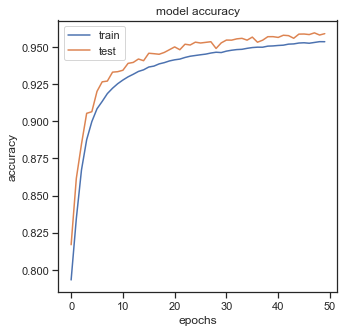

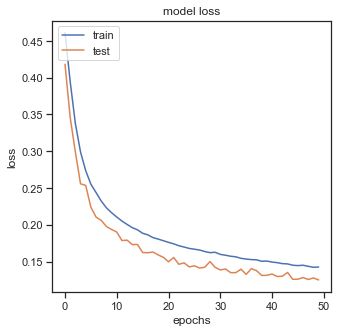

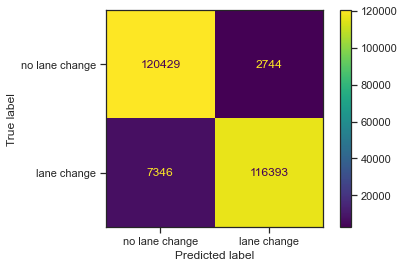

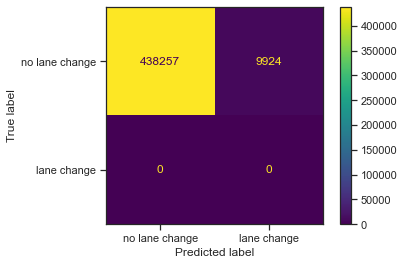

In [45]:
history_backup2 = dict()
for batch_size_s in [50]:
    print('----------------------------------------------------------------------------------------')
    print('batch size : ',batch_size_s)
    print('----------------------------------------------------------------------------------------')
    history_backup2[batch_size_s] = dict()
    history_backup2[batch_size_s]['model'] = model.fit(X_train, y_train, batch_size = batch_size_s ,epochs = 50,shuffle = True,validation_data=(X_val, y_val))
    history_backup2[batch_size_s]['evaluate'] = model.evaluate(X_test ,y_test, batch_size = batch_size_s )
    print('----------------------------------------------------------------------------------------')
    history_backup2[batch_size_s]['predict'] = model.predict(X_test ) # y_test
    print('----------------------------------------------------------------------------------------')
    summarizer(history_backup2[batch_size_s]['model'],5,5)
    print('----------------------------------------------------------------------------------------')
    print_final_results(history_backup2[batch_size_s],y_test,'predict')
    print('----------------------------------------------------------------------------------------')
    history_backup2[batch_size_s]['predict extra'] = model.predict(extra_X)
    print_final_results(history_backup2[batch_size_s],extra_y,'predict extra')
    print('----------------------------------------------------------------------------------------')
    print('----------------------------------------------------------------------------------------')

                precision    recall  f1-score   support

no lane change       0.96      0.97      0.96     82962
   lane change       0.97      0.96      0.96     83581

      accuracy                           0.96    166543
     macro avg       0.96      0.96      0.96    166543
  weighted avg       0.96      0.96      0.96    166543

-----------------------------------------------------------------------------------------------------------------
counts: 
| TP | True - positives | lane change - True prediction:  80244
| TN | True - negatives | lane change - False prediction:  3337
| FN | False - Negatives | No lane change - True prediction:  2832
| TP | True - Negatives | No lane change - False prediction:  80130
percentages: 
| TP | True - positives | lane change - True prediction: 0.4818 %
| TN | True - negatives | lane change - False prediction: 0.02 %
| FN | False - Negatives | No lane change - True prediction: 0.017 %
| TP | True - Negatives | No lane change - False prediction: 

()

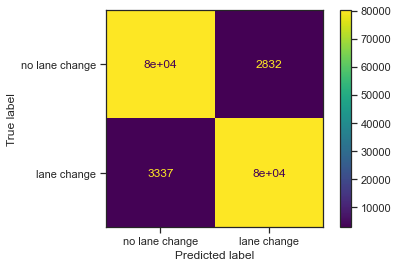

In [39]:
print_final_results(history_backup[batch_size_s],y_test,'predict')

                precision    recall  f1-score   support

no lane change       1.00      0.97      0.98    854378
   lane change       0.00      0.00      0.00         0

      accuracy                           0.97    854378
     macro avg       0.50      0.48      0.49    854378
  weighted avg       1.00      0.97      0.98    854378

-----------------------------------------------------------------------------------------------------------------
counts: 
| TP | True - positives | lane change - True prediction:  0
| TN | True - negatives | lane change - False prediction:  0
| FN | False - Negatives | No lane change - True prediction:  29558
| TP | True - Negatives | No lane change - False prediction:  824820
percentages: 
| TP | True - positives | lane change - True prediction: 0.0 %
| TN | True - negatives | lane change - False prediction: 0.0 %
| FN | False - Negatives | No lane change - True prediction: 0.0346 %
| TP | True - Negatives | No lane change - False prediction: 0.9654 %

()

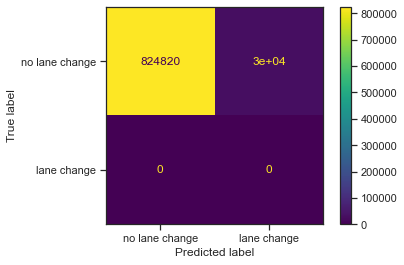

In [40]:
print_final_results(history_backup[batch_size_s],extra_y,'predict extra')

In [27]:
def translate(y_to_trans):
    if y_to_trans == 1:
        out_c = ' lane change'
    else:
        out_c = 'no lane change'
    return(out_c )
def show_how_it_predicted(X_s,y_s,pred_ys):
    
    alls = list(pd.Series(np.arange(0,len(X_s))))
    ch = random.choice(alls)
    print('neural network timeseries input (Xs)'+ ' for random picked sample: '+str(ch))
    print('displaying first 20 lines of input sequences')
    print()
    print(X_test[ch][0:20])
    print('---------------------------------------')
    print('real class to predict in binary form (Y)')
    print(y_test[ch])
    print('real class to predict in class form (Y)')
    print(translate(y_test[ch]))
    print('---------------------------------------')
    print('output prediction in propability: (y)')
    print(history_backup[batch_size_s]['predict'][ch])
    print('output prediction in binary form: (y)')
    print(np.round(history_backup[batch_size_s]['predict'][ch]))
    print('output prediction in class form: (y)')
    print(translate(np.round(history_backup[batch_size_s]['predict'][ch])))
    return()

In [34]:
show_how_it_predicted(X_test,y_test,history_backup[batch_size_s]['predict'])

neural network timeseries input (Xs) for random picked sample: 92781
displaying first 20 lines of input sequences

[[0.53355  0.09207  0.5      0.4      0.404931 1.       0.4      1.
  0.49753  1.       1.       0.      ]
 [0.53394  0.09281  0.5      0.4      0.405099 1.       0.4      0.496529
  0.598597 1.       1.       0.      ]
 [0.53424  0.09369  0.5      0.4      0.405967 1.       0.4      0.495368
  0.595038 1.       1.       0.      ]
 [0.53445  0.09464  0.5      0.513183 0.40718  1.       0.401523 0.49406
  1.       1.       0.35     0.      ]
 [0.53457  0.0956   0.5      0.35     0.408735 1.       0.400311 1.
  0.492603 1.       1.       0.      ]
 [0.53461  0.09654  0.5      0.35     0.4      1.       0.399143 0.491127
  0.584709 1.       1.       0.      ]
 [0.53457  0.09738  0.5      0.511219 0.4      1.       0.398084 0.489699
  1.       1.       0.35     0.      ]
 [0.53446  0.09809  0.5      0.35     0.4      1.       0.397198 0.488383
  0.579014 1.       1.       0.  

()

In [ ]:
list(pd.Series(np.arange(0,len(X_test))))

In [ ]:
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC